<a href="https://colab.research.google.com/github/shauryasawai/Medical_Research_Lab_Task/blob/main/train_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [14]:
import os
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, random_split
import cv2
from tqdm import tqdm
import matplotlib.pyplot as plt
from pathlib import Path

In [15]:
# ============================================================================
# 1. DATASET CLASS
# ============================================================================

class FetalLandmarkDataset(Dataset):
    """Dataset for fetal ultrasound landmark detection"""

    def __init__(self, csv_path, image_dir, img_size=256):
        """
        Args:
            csv_path: Path to CSV with columns [image_name, ofd_1_x, ofd_1_y, ..., bpd_2_y]
            image_dir: Directory containing ultrasound images
            img_size: Target image size (default: 256x256)
        """
        self.df = pd.read_csv(csv_path)
        self.image_dir = image_dir
        self.img_size = img_size

        # Store original image dimensions for denormalization
        self.original_sizes = {}

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]

        # Load image
        img_name = row['image_name']
        img_path = os.path.join(self.image_dir, img_name)
        image = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)

        if image is None:
            raise FileNotFoundError(f"Image not found: {img_path}")

        # Store original size
        orig_h, orig_w = image.shape
        self.original_sizes[img_name] = (orig_w, orig_h)

        # Resize image
        image = cv2.resize(image, (self.img_size, self.img_size))

        # Normalize image to [0, 1]
        image = image.astype(np.float32) / 255.0

        # Convert to tensor (1, H, W)
        image = torch.tensor(image, dtype=torch.float32).unsqueeze(0)

        # Extract landmarks (8 values)
        landmarks = row[1:9].values.astype(np.float32)

        # Normalize coordinates to [0, 1]
        # Assumes landmarks are given in original image coordinates
        landmarks[0::2] = landmarks[0::2] / orig_w  # x coordinates
        landmarks[1::2] = landmarks[1::2] / orig_h  # y coordinates

        landmarks = torch.tensor(landmarks, dtype=torch.float32)

        return image, landmarks, img_name

In [16]:
# ============================================================================
# 2. MODEL ARCHITECTURE
# ============================================================================

class LandmarkCNN(nn.Module):
    """CNN for landmark regression"""

    def __init__(self, num_landmarks=8):
        super(LandmarkCNN, self).__init__()

        # Feature extraction layers
        self.features = nn.Sequential(
            # Block 1
            nn.Conv2d(1, 32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(inplace=True),
            nn.Conv2d(32, 32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2, 2),  # 256 -> 128

            # Block 2
            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.Conv2d(64, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2, 2),  # 128 -> 64

            # Block 3
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.Conv2d(128, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2, 2),  # 64 -> 32

            # Block 4
            nn.Conv2d(128, 256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2, 2),  # 32 -> 16
        )

        # Regression head
        self.regressor = nn.Sequential(
            nn.Flatten(),
            nn.Linear(256 * 16 * 16, 512),
            nn.ReLU(inplace=True),
            nn.Dropout(0.5),
            nn.Linear(512, 256),
            nn.ReLU(inplace=True),
            nn.Dropout(0.3),
            nn.Linear(256, num_landmarks)
        )

    def forward(self, x):
        x = self.features(x)
        x = self.regressor(x)
        return x

In [17]:
# ============================================================================
# 3. TRAINING UTILITIES
# ============================================================================

def calculate_pixel_error(pred, target, img_size=256):
    """
    Calculate mean Euclidean distance error in pixels

    Args:
        pred: Predicted landmarks (normalized, 0-1)
        target: Ground truth landmarks (normalized, 0-1)
        img_size: Image size for denormalization

    Returns:
        Mean pixel error across all landmarks
    """
    # Denormalize to pixel coordinates
    pred_pixels = pred.cpu().numpy() * img_size
    target_pixels = target.cpu().numpy() * img_size

    # Reshape to (batch, num_points, 2)
    pred_points = pred_pixels.reshape(-1, 4, 2)
    target_points = target_pixels.reshape(-1, 4, 2)

    # Calculate Euclidean distance for each point
    distances = np.sqrt(np.sum((pred_points - target_points) ** 2, axis=2))

    # Return mean distance
    return distances.mean()


def train_epoch(model, dataloader, criterion, optimizer, device):
    """Train for one epoch"""
    model.train()
    total_loss = 0
    total_error = 0

    pbar = tqdm(dataloader, desc="Training")
    for images, landmarks, _ in pbar:
        images = images.to(device)
        landmarks = landmarks.to(device)

        # Forward pass
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, landmarks)

        # Backward pass
        loss.backward()
        optimizer.step()

        # Calculate metrics
        total_loss += loss.item()
        error = calculate_pixel_error(outputs.detach(), landmarks.detach())
        total_error += error

        pbar.set_postfix({'loss': f'{loss.item():.4f}', 'error': f'{error:.2f}px'})

    avg_loss = total_loss / len(dataloader)
    avg_error = total_error / len(dataloader)

    return avg_loss, avg_error


def validate(model, dataloader, criterion, device):
    """Validate the model"""
    model.eval()
    total_loss = 0
    total_error = 0

    with torch.no_grad():
        for images, landmarks, _ in tqdm(dataloader, desc="Validating"):
            images = images.to(device)
            landmarks = landmarks.to(device)

            outputs = model(images)
            loss = criterion(outputs, landmarks)

            total_loss += loss.item()
            error = calculate_pixel_error(outputs, landmarks)
            total_error += error

    avg_loss = total_loss / len(dataloader)
    avg_error = total_error / len(dataloader)

    return avg_loss, avg_error

In [18]:
# ============================================================================
# 4. MEASUREMENT UTILITIES
# ============================================================================

def calculate_measurements(landmarks, img_size=256):
    """
    Calculate BPD and OFD from predicted landmarks

    Args:
        landmarks: Array of 8 values [ofd_1_x, ofd_1_y, ofd_2_x, ofd_2_y,
                                       bpd_1_x, bpd_1_y, bpd_2_x, bpd_2_y]
        img_size: Image size for denormalization

    Returns:
        (OFD, BPD) in pixels
    """
    # Denormalize
    landmarks_pixels = landmarks * img_size

    # Extract points
    ofd_1 = landmarks_pixels[0:2]
    ofd_2 = landmarks_pixels[2:4]
    bpd_1 = landmarks_pixels[4:6]
    bpd_2 = landmarks_pixels[6:8]

    # Calculate distances
    OFD = np.linalg.norm(ofd_1 - ofd_2)
    BPD = np.linalg.norm(bpd_1 - bpd_2)

    return OFD, BPD


def visualize_predictions(model, dataset, device, num_samples=4, save_path=None):
    """Visualize model predictions"""
    model.eval()

    fig, axes = plt.subplots(2, num_samples, figsize=(4*num_samples, 8))
    if num_samples == 1:
        axes = axes.reshape(-1, 1)

    indices = np.random.choice(len(dataset), num_samples, replace=False)

    with torch.no_grad():
        for i, idx in enumerate(indices):
            image, gt_landmarks, img_name = dataset[idx]
            image_input = image.unsqueeze(0).to(device)

            # Predict
            pred_landmarks = model(image_input).cpu().numpy()[0]
            gt_landmarks = gt_landmarks.numpy()

            # Denormalize
            pred_pixels = pred_landmarks * 256
            gt_pixels = gt_landmarks * 256

            # Calculate measurements
            pred_ofd, pred_bpd = calculate_measurements(pred_landmarks)
            gt_ofd, gt_bpd = calculate_measurements(gt_landmarks.numpy())

            # Plot
            img_display = image.squeeze().numpy()

            # Ground truth
            axes[0, i].imshow(img_display, cmap='gray')
            axes[0, i].plot([gt_pixels[0], gt_pixels[2]], [gt_pixels[1], gt_pixels[3]],
                           'g-', linewidth=2, label='OFD')
            axes[0, i].plot([gt_pixels[4], gt_pixels[6]], [gt_pixels[5], gt_pixels[7]],
                           'b-', linewidth=2, label='BPD')
            axes[0, i].scatter(gt_pixels[0::2], gt_pixels[1::2], c='red', s=50)
            axes[0, i].set_title(f'Ground Truth\nOFD: {gt_ofd:.1f}px, BPD: {gt_bpd:.1f}px')
            axes[0, i].axis('off')
            if i == 0:
                axes[0, i].legend()

            # Prediction
            axes[1, i].imshow(img_display, cmap='gray')
            axes[1, i].plot([pred_pixels[0], pred_pixels[2]], [pred_pixels[1], pred_pixels[3]],
                           'g-', linewidth=2, label='OFD')
            axes[1, i].plot([pred_pixels[4], pred_pixels[6]], [pred_pixels[5], pred_pixels[7]],
                           'b-', linewidth=2, label='BPD')
            axes[1, i].scatter(pred_pixels[0::2], pred_pixels[1::2], c='red', s=50)
            axes[1, i].set_title(f'Prediction\nOFD: {pred_ofd:.1f}px, BPD: {pred_bpd:.1f}px')
            axes[1, i].axis('off')
            if i == 0:
                axes[1, i].legend()

    plt.tight_layout()
    if save_path:
        plt.savefig(save_path, dpi=150, bbox_inches='tight')
        print(f"✓ Predictions saved to: {save_path}")
    else:
        plt.savefig('predictions.png', dpi=150, bbox_inches='tight')
        print("Visualization saved as 'predictions.png'")
    plt.show()

In [19]:
# ============================================================================
# 5. FILE UPLOAD FOR GOOGLE COLAB
# ============================================================================

def upload_files_colab():
    """Upload CSV and images folder in Google Colab"""
    from google.colab import files
    import zipfile
    import shutil

    print("=" * 60)
    print("STEP 1: Upload CSV file")
    print("=" * 60)
    uploaded_csv = files.upload()
    csv_filename = list(uploaded_csv.keys())[0]
    print(f"✓ CSV uploaded: {csv_filename}\n")

    print("=" * 60)
    print("STEP 2: Upload images folder as ZIP")
    print("=" * 60)
    print("Please zip your images folder first, then upload the ZIP file")
    uploaded_zip = files.upload()
    zip_filename = list(uploaded_zip.keys())[0]
    print(f"✓ ZIP uploaded: {zip_filename}\n")

    # Extract images
    print("Extracting images...")
    with zipfile.ZipFile(zip_filename, 'r') as zip_ref:
        zip_ref.extractall('.')

    # Find the extracted folder
    extracted_folders = [d for d in os.listdir('.') if os.path.isdir(d) and d != 'sample_data']
    if extracted_folders:
        image_dir = extracted_folders[0]
    else:
        image_dir = 'images'

    print(f"✓ Images extracted to: {image_dir}\n")

    # Count images
    image_files = [f for f in os.listdir(image_dir) if f.endswith(('.png', '.jpg', '.jpeg'))]
    print(f"Found {len(image_files)} images")

    return csv_filename, image_dir

In [20]:
# ============================================================================
# 6. MODEL CHECKPOINT MANAGER
# ============================================================================

class ModelCheckpointManager:
    """Manages model checkpoints for different experiments"""

    def __init__(self, base_dir='experiments'):
        self.base_dir = base_dir
        os.makedirs(base_dir, exist_ok=True)
        self.experiment_log = os.path.join(base_dir, 'experiment_log.csv')

        # Initialize log if it doesn't exist
        if not os.path.exists(self.experiment_log):
            log_df = pd.DataFrame(columns=[
                'experiment_id', 'timestamp', 'description', 'batch_size',
                'learning_rate', 'num_epochs', 'img_size', 'best_val_error',
                'best_epoch', 'total_params', 'model_path'
            ])
            log_df.to_csv(self.experiment_log, index=False)

    def create_experiment(self, description=''):
        """Create a new experiment directory"""
        timestamp = pd.Timestamp.now().strftime('%Y%m%d_%H%M%S')
        exp_id = f"exp_{timestamp}"
        exp_dir = os.path.join(self.base_dir, exp_id)
        os.makedirs(exp_dir, exist_ok=True)

        print(f"\n{'='*60}")
        print(f"📁 Experiment Directory: {exp_dir}")
        print(f"📝 Description: {description}")
        print(f"{'='*60}\n")

        return exp_id, exp_dir

    def save_checkpoint(self, exp_dir, epoch, model, optimizer, scheduler,
                       val_error, is_best=False):
        """Save model checkpoint"""
        checkpoint = {
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'scheduler_state_dict': scheduler.state_dict(),
            'val_error': val_error,
        }

        # Save latest checkpoint
        latest_path = os.path.join(exp_dir, 'checkpoint_latest.pth')
        torch.save(checkpoint, latest_path)

        # Save best checkpoint
        if is_best:
            best_path = os.path.join(exp_dir, 'checkpoint_best.pth')
            torch.save(checkpoint, best_path)
            return best_path

        # Save epoch checkpoint (every 10 epochs)
        if epoch % 10 == 0:
            epoch_path = os.path.join(exp_dir, f'checkpoint_epoch_{epoch}.pth')
            torch.save(checkpoint, epoch_path)

        return latest_path

    def save_config(self, exp_dir, config):
        """Save experiment configuration"""
        import json
        config_path = os.path.join(exp_dir, 'config.json')
        with open(config_path, 'w') as f:
            json.dump(config, f, indent=4)
        print(f"✓ Configuration saved to: {config_path}")

    def save_history(self, exp_dir, history):
        """Save training history"""
        history_path = os.path.join(exp_dir, 'training_history.csv')
        history_df = pd.DataFrame(history)
        history_df.to_csv(history_path, index=False)
        print(f"✓ Training history saved to: {history_path}")

    def log_experiment(self, exp_id, config, best_val_error, best_epoch,
                      total_params, model_path):
        """Log experiment results"""
        log_df = pd.read_csv(self.experiment_log)

        new_entry = {
            'experiment_id': exp_id,
            'timestamp': pd.Timestamp.now(),
            'description': config.get('description', ''),
            'batch_size': config['batch_size'],
            'learning_rate': config['learning_rate'],
            'num_epochs': config['num_epochs'],
            'img_size': config['img_size'],
            'best_val_error': best_val_error,
            'best_epoch': best_epoch,
            'total_params': total_params,
            'model_path': model_path
        }

        log_df = pd.concat([log_df, pd.DataFrame([new_entry])], ignore_index=True)
        log_df.to_csv(self.experiment_log, index=False)
        print(f"\n✓ Experiment logged to: {self.experiment_log}")

    def print_experiment_summary(self):
        """Print summary of all experiments"""
        if os.path.exists(self.experiment_log):
            log_df = pd.read_csv(self.experiment_log)
            print("\n" + "="*80)
            print("📊 EXPERIMENT SUMMARY")
            print("="*80)
            print(log_df.to_string(index=False))
            print("="*80 + "\n")
        else:
            print("No experiments logged yet.")

    def load_best_model(self, exp_id, model):
        """Load the best model from an experiment"""
        exp_dir = os.path.join(self.base_dir, exp_id)
        best_path = os.path.join(exp_dir, 'checkpoint_best.pth')

        if os.path.exists(best_path):
            checkpoint = torch.load(best_path)
            model.load_state_dict(checkpoint['model_state_dict'])
            print(f"✓ Loaded best model from: {best_path}")
            print(f"  Epoch: {checkpoint['epoch']}, Val Error: {checkpoint['val_error']:.2f}px")
            return model
        else:
            print(f"❌ Best model not found at: {best_path}")
            return None


🔬 EXPERIMENT 1: Baseline Model

📁 Experiment Directory: experiments/exp_20251227_121436
📝 Description: Baseline: LR=1e-3, BS=16, Epochs=50

✓ Configuration saved to: experiments/exp_20251227_121436/config.json

Using device: cpu

Loading dataset...
Train samples: 497, Validation samples: 125


/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Model parameters: 34,271,336

Starting training...

Epoch 1/50


Validating: 100%|██████████| 8/8 [00:27<00:00,  3.49s/it]


Train Loss: 26.0746, Train Error: 990.29px
Val Loss: 0.1436, Val Error: 121.59px
Learning Rate: 0.001000
✓ New best model! Error: 121.59px (saved to experiments/exp_20251227_121436/checkpoint_best.pth)

Epoch 2/50


Validating: 100%|██████████| 8/8 [00:29<00:00,  3.72s/it]


Train Loss: 0.4774, Train Error: 209.03px
Val Loss: 0.1358, Val Error: 125.45px
Learning Rate: 0.001000

Epoch 3/50


Validating: 100%|██████████| 8/8 [00:26<00:00,  3.30s/it]


Train Loss: 0.2281, Train Error: 147.43px
Val Loss: 0.1383, Val Error: 127.13px
Learning Rate: 0.001000

Epoch 4/50


Validating: 100%|██████████| 8/8 [00:28<00:00,  3.50s/it]


Train Loss: 0.1582, Train Error: 124.14px
Val Loss: 0.1157, Val Error: 115.16px
Learning Rate: 0.001000
✓ New best model! Error: 115.16px (saved to experiments/exp_20251227_121436/checkpoint_best.pth)

Epoch 5/50


Validating: 100%|██████████| 8/8 [00:29<00:00,  3.66s/it]


Train Loss: 0.1186, Train Error: 108.52px
Val Loss: 0.0978, Val Error: 105.06px
Learning Rate: 0.001000
✓ New best model! Error: 105.06px (saved to experiments/exp_20251227_121436/checkpoint_best.pth)

Epoch 6/50


Validating: 100%|██████████| 8/8 [00:27<00:00,  3.40s/it]


Train Loss: 0.1066, Train Error: 102.97px
Val Loss: 0.1023, Val Error: 107.54px
Learning Rate: 0.001000

Epoch 7/50


Validating: 100%|██████████| 8/8 [00:27<00:00,  3.45s/it]


Train Loss: 0.0895, Train Error: 93.98px
Val Loss: 0.0884, Val Error: 99.48px
Learning Rate: 0.001000
✓ New best model! Error: 99.48px (saved to experiments/exp_20251227_121436/checkpoint_best.pth)

Epoch 8/50


Validating: 100%|██████████| 8/8 [00:26<00:00,  3.28s/it]


Train Loss: 0.0835, Train Error: 91.27px
Val Loss: 0.0886, Val Error: 100.03px
Learning Rate: 0.001000

Epoch 9/50


Validating: 100%|██████████| 8/8 [00:27<00:00,  3.44s/it]


Train Loss: 0.0851, Train Error: 89.19px
Val Loss: 0.0791, Val Error: 92.61px
Learning Rate: 0.001000
✓ New best model! Error: 92.61px (saved to experiments/exp_20251227_121436/checkpoint_best.pth)

Epoch 10/50


Validating: 100%|██████████| 8/8 [00:37<00:00,  4.72s/it]


Train Loss: 0.0742, Train Error: 83.97px
Val Loss: 0.0860, Val Error: 97.91px
Learning Rate: 0.001000

Epoch 11/50


Validating: 100%|██████████| 8/8 [00:26<00:00,  3.37s/it]


Train Loss: 0.0677, Train Error: 81.25px
Val Loss: 0.0743, Val Error: 90.08px
Learning Rate: 0.001000
✓ New best model! Error: 90.08px (saved to experiments/exp_20251227_121436/checkpoint_best.pth)

Epoch 12/50


Validating: 100%|██████████| 8/8 [00:26<00:00,  3.33s/it]


Train Loss: 0.0610, Train Error: 77.17px
Val Loss: 0.0803, Val Error: 93.46px
Learning Rate: 0.001000

Epoch 13/50


Validating: 100%|██████████| 8/8 [00:29<00:00,  3.65s/it]


Train Loss: 0.0612, Train Error: 77.42px
Val Loss: 0.0820, Val Error: 95.24px
Learning Rate: 0.001000

Epoch 14/50


Validating: 100%|██████████| 8/8 [00:26<00:00,  3.28s/it]


Train Loss: 0.0572, Train Error: 74.92px
Val Loss: 0.0757, Val Error: 89.73px
Learning Rate: 0.001000
✓ New best model! Error: 89.73px (saved to experiments/exp_20251227_121436/checkpoint_best.pth)

Epoch 15/50


Validating: 100%|██████████| 8/8 [00:29<00:00,  3.67s/it]


Train Loss: 0.0563, Train Error: 73.73px
Val Loss: 0.0723, Val Error: 88.01px
Learning Rate: 0.001000
✓ New best model! Error: 88.01px (saved to experiments/exp_20251227_121436/checkpoint_best.pth)

Epoch 16/50


Validating: 100%|██████████| 8/8 [00:28<00:00,  3.51s/it]


Train Loss: 0.0489, Train Error: 68.87px
Val Loss: 0.0756, Val Error: 90.82px
Learning Rate: 0.001000

Epoch 17/50


Validating: 100%|██████████| 8/8 [00:28<00:00,  3.51s/it]


Train Loss: 0.0476, Train Error: 67.76px
Val Loss: 0.0782, Val Error: 91.91px
Learning Rate: 0.001000

Epoch 18/50


Validating: 100%|██████████| 8/8 [00:28<00:00,  3.56s/it]


Train Loss: 0.0482, Train Error: 68.26px
Val Loss: 0.0742, Val Error: 89.38px
Learning Rate: 0.001000

Epoch 19/50


Validating: 100%|██████████| 8/8 [00:25<00:00,  3.13s/it]


Train Loss: 0.0508, Train Error: 68.92px
Val Loss: 0.0750, Val Error: 90.53px
Learning Rate: 0.001000

Epoch 20/50


Validating: 100%|██████████| 8/8 [00:26<00:00,  3.32s/it]


Train Loss: 0.0516, Train Error: 69.73px
Val Loss: 0.0597, Val Error: 79.41px
Learning Rate: 0.001000
✓ New best model! Error: 79.41px (saved to experiments/exp_20251227_121436/checkpoint_best.pth)

Epoch 21/50


Validating: 100%|██████████| 8/8 [00:26<00:00,  3.30s/it]


Train Loss: 0.0498, Train Error: 68.92px
Val Loss: 0.0732, Val Error: 87.75px
Learning Rate: 0.001000

Epoch 22/50


Validating: 100%|██████████| 8/8 [00:25<00:00,  3.23s/it]


Train Loss: 0.0475, Train Error: 67.18px
Val Loss: 0.0710, Val Error: 87.23px
Learning Rate: 0.001000

Epoch 23/50


Validating: 100%|██████████| 8/8 [00:26<00:00,  3.35s/it]


Train Loss: 0.0458, Train Error: 65.53px
Val Loss: 0.0666, Val Error: 83.62px
Learning Rate: 0.001000

Epoch 24/50


Validating: 100%|██████████| 8/8 [00:25<00:00,  3.19s/it]


Train Loss: 0.0516, Train Error: 69.31px
Val Loss: 0.0751, Val Error: 90.42px
Learning Rate: 0.001000

Epoch 25/50


Validating: 100%|██████████| 8/8 [00:26<00:00,  3.26s/it]


Train Loss: 0.0477, Train Error: 66.91px
Val Loss: 0.0652, Val Error: 83.29px
Learning Rate: 0.001000

Epoch 26/50


Validating: 100%|██████████| 8/8 [00:26<00:00,  3.30s/it]


Train Loss: 0.0444, Train Error: 65.57px
Val Loss: 0.0902, Val Error: 99.70px
Learning Rate: 0.000500

Epoch 27/50


Validating: 100%|██████████| 8/8 [00:29<00:00,  3.65s/it]


Train Loss: 0.0398, Train Error: 60.65px
Val Loss: 0.0820, Val Error: 94.57px
Learning Rate: 0.000500

Epoch 28/50


Validating: 100%|██████████| 8/8 [00:28<00:00,  3.61s/it]


Train Loss: 0.0401, Train Error: 60.51px
Val Loss: 0.0743, Val Error: 89.80px
Learning Rate: 0.000500

Epoch 29/50


Validating: 100%|██████████| 8/8 [00:27<00:00,  3.47s/it]


Train Loss: 0.0387, Train Error: 60.19px
Val Loss: 0.0737, Val Error: 89.46px
Learning Rate: 0.000500

Epoch 30/50


Validating: 100%|██████████| 8/8 [00:29<00:00,  3.68s/it]


Train Loss: 0.0394, Train Error: 60.09px
Val Loss: 0.0746, Val Error: 89.99px
Learning Rate: 0.000500

Epoch 31/50


Validating: 100%|██████████| 8/8 [00:40<00:00,  5.05s/it]


Train Loss: 0.0347, Train Error: 56.36px
Val Loss: 0.0687, Val Error: 86.13px
Learning Rate: 0.000500

Epoch 32/50


Validating: 100%|██████████| 8/8 [00:26<00:00,  3.27s/it]


Train Loss: 0.0354, Train Error: 57.12px
Val Loss: 0.0643, Val Error: 82.57px
Learning Rate: 0.000250

Epoch 33/50


Validating: 100%|██████████| 8/8 [00:26<00:00,  3.31s/it]


Train Loss: 0.0355, Train Error: 56.60px
Val Loss: 0.0588, Val Error: 78.47px
Learning Rate: 0.000250
✓ New best model! Error: 78.47px (saved to experiments/exp_20251227_121436/checkpoint_best.pth)

Epoch 34/50


Validating: 100%|██████████| 8/8 [00:26<00:00,  3.26s/it]


Train Loss: 0.0345, Train Error: 55.72px
Val Loss: 0.0655, Val Error: 83.61px
Learning Rate: 0.000250

Epoch 35/50


Validating: 100%|██████████| 8/8 [00:27<00:00,  3.41s/it]


Train Loss: 0.0359, Train Error: 57.26px
Val Loss: 0.0673, Val Error: 84.88px
Learning Rate: 0.000250

Epoch 36/50


Validating: 100%|██████████| 8/8 [00:27<00:00,  3.43s/it]


Train Loss: 0.0339, Train Error: 55.79px
Val Loss: 0.0676, Val Error: 85.38px
Learning Rate: 0.000250

Epoch 37/50


Validating: 100%|██████████| 8/8 [00:27<00:00,  3.47s/it]


Train Loss: 0.0364, Train Error: 58.02px
Val Loss: 0.0655, Val Error: 84.00px
Learning Rate: 0.000250

Epoch 38/50


Validating: 100%|██████████| 8/8 [00:28<00:00,  3.57s/it]


Train Loss: 0.0350, Train Error: 56.52px
Val Loss: 0.0653, Val Error: 83.61px
Learning Rate: 0.000250

Epoch 39/50


Validating: 100%|██████████| 8/8 [00:26<00:00,  3.32s/it]


Train Loss: 0.0326, Train Error: 54.56px
Val Loss: 0.0611, Val Error: 80.69px
Learning Rate: 0.000125

Epoch 40/50


Validating: 100%|██████████| 8/8 [00:27<00:00,  3.46s/it]


Train Loss: 0.0332, Train Error: 54.80px
Val Loss: 0.0612, Val Error: 80.58px
Learning Rate: 0.000125

Epoch 41/50


Validating: 100%|██████████| 8/8 [00:28<00:00,  3.59s/it]


Train Loss: 0.0313, Train Error: 53.01px
Val Loss: 0.0653, Val Error: 83.51px
Learning Rate: 0.000125

Epoch 42/50


Validating: 100%|██████████| 8/8 [00:26<00:00,  3.29s/it]


Train Loss: 0.0309, Train Error: 52.68px
Val Loss: 0.0596, Val Error: 79.44px
Learning Rate: 0.000125

Epoch 43/50


Validating: 100%|██████████| 8/8 [00:28<00:00,  3.60s/it]


Train Loss: 0.0310, Train Error: 52.16px
Val Loss: 0.0572, Val Error: 77.29px
Learning Rate: 0.000125
✓ New best model! Error: 77.29px (saved to experiments/exp_20251227_121436/checkpoint_best.pth)

Epoch 44/50


Validating: 100%|██████████| 8/8 [00:25<00:00,  3.16s/it]


Train Loss: 0.0325, Train Error: 54.14px
Val Loss: 0.0579, Val Error: 77.99px
Learning Rate: 0.000125

Epoch 45/50


Validating: 100%|██████████| 8/8 [00:26<00:00,  3.31s/it]


Train Loss: 0.0312, Train Error: 53.26px
Val Loss: 0.0550, Val Error: 75.52px
Learning Rate: 0.000125
✓ New best model! Error: 75.52px (saved to experiments/exp_20251227_121436/checkpoint_best.pth)

Epoch 46/50


Validating: 100%|██████████| 8/8 [00:28<00:00,  3.62s/it]


Train Loss: 0.0316, Train Error: 53.42px
Val Loss: 0.0542, Val Error: 75.35px
Learning Rate: 0.000125
✓ New best model! Error: 75.35px (saved to experiments/exp_20251227_121436/checkpoint_best.pth)

Epoch 47/50


Validating: 100%|██████████| 8/8 [00:38<00:00,  4.87s/it]


Train Loss: 0.0342, Train Error: 55.28px
Val Loss: 0.0558, Val Error: 76.53px
Learning Rate: 0.000125

Epoch 48/50


Validating: 100%|██████████| 8/8 [00:26<00:00,  3.33s/it]


Train Loss: 0.0302, Train Error: 51.87px
Val Loss: 0.0561, Val Error: 76.75px
Learning Rate: 0.000125

Epoch 49/50


Validating: 100%|██████████| 8/8 [00:29<00:00,  3.63s/it]


Train Loss: 0.0319, Train Error: 53.56px
Val Loss: 0.0544, Val Error: 75.41px
Learning Rate: 0.000125

Epoch 50/50


Validating: 100%|██████████| 8/8 [00:29<00:00,  3.67s/it]


Train Loss: 0.0314, Train Error: 52.73px
Val Loss: 0.0536, Val Error: 74.83px
Learning Rate: 0.000125
✓ New best model! Error: 74.83px (saved to experiments/exp_20251227_121436/checkpoint_best.pth)

Training complete!
Best validation error: 74.83px at epoch 50

✓ Training history saved to: experiments/exp_20251227_121436/training_history.csv

✓ Experiment logged to: experiments/experiment_log.csv


/tmp/ipython-input-560149918.py:98: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  log_df = pd.concat([log_df, pd.DataFrame([new_entry])], ignore_index=True)


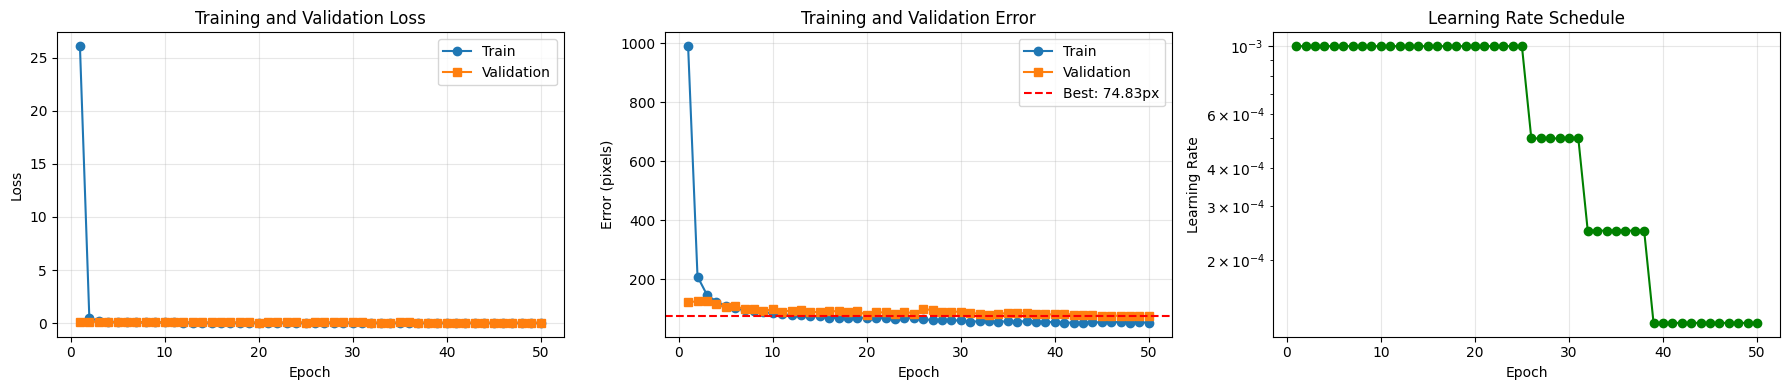

✓ Training curves saved to: experiments/exp_20251227_121436/training_curves.png

Generating predictions visualization...


AttributeError: 'numpy.ndarray' object has no attribute 'numpy'

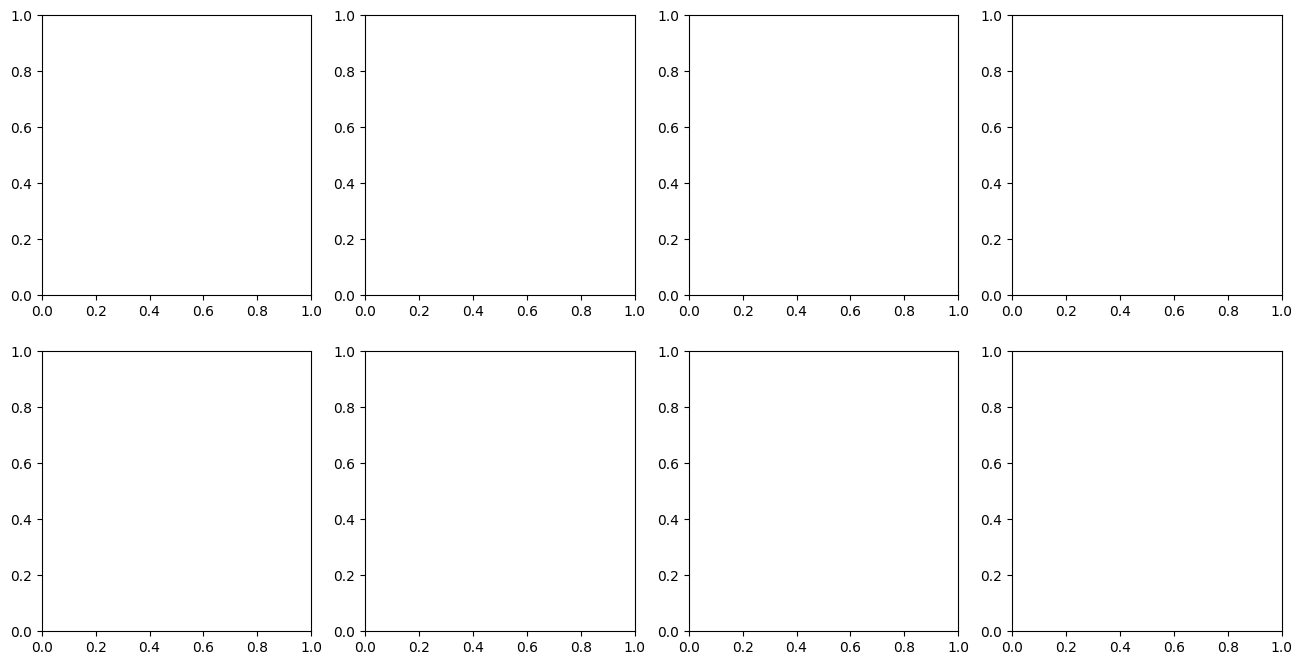

In [25]:
# ============================================================================
# 7. MAIN TRAINING SCRIPT
# ============================================================================

def main(use_colab_upload=True, experiment_description=''):
    """
    Main training function

    Args:
        use_colab_upload: If True, will prompt for file upload in Colab.
                         If False, uses hardcoded paths (for local execution)
        experiment_description: Description of this experiment/hypothesis
    """
    # Configuration
    config = {
        'batch_size': 16,
        'num_epochs': 50,
        'learning_rate': 1e-3,
        'img_size': 256,
        'train_split': 0.8,
        'description': experiment_description
    }

    BATCH_SIZE = config['batch_size']
    NUM_EPOCHS = config['num_epochs']
    LEARNING_RATE = config['learning_rate']
    IMG_SIZE = config['img_size']
    TRAIN_SPLIT = config['train_split']

    # Initialize checkpoint manager
    checkpoint_manager = ModelCheckpointManager(base_dir='experiments')
    exp_id, exp_dir = checkpoint_manager.create_experiment(experiment_description)

    # Save configuration
    checkpoint_manager.save_config(exp_dir, config)

    CSV_PATH = "role_challenge_dataset_ground_truth.csv"
    IMAGE_DIR = "images"

    # Device
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    print(f"\n{'='*60}")
    print(f"Using device: {device}")
    print(f"{'='*60}\n")

    # Load dataset
    print("Loading dataset...")
    full_dataset = FetalLandmarkDataset(CSV_PATH, IMAGE_DIR, img_size=IMG_SIZE)

    # Split dataset
    train_size = int(TRAIN_SPLIT * len(full_dataset))
    val_size = len(full_dataset) - train_size
    train_dataset, val_dataset = random_split(
        full_dataset, [train_size, val_size],
        generator=torch.Generator().manual_seed(42)
    )

    print(f"Train samples: {train_size}, Validation samples: {val_size}")

    # Create dataloaders
    train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE,
                             shuffle=True, num_workers=4)
    val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE,
                           shuffle=False, num_workers=4)

    # Create model
    model = LandmarkCNN(num_landmarks=8).to(device)
    print(f"Model parameters: {sum(p.numel() for p in model.parameters()):,}")

    # Loss and optimizer
    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(
        optimizer, mode='min', factor=0.5, patience=5
    )

    # Get total parameters
    total_params = sum(p.numel() for p in model.parameters())

    # Training loop
    best_val_error = float('inf')
    best_epoch = 0
    history = {'epoch': [], 'train_loss': [], 'train_error': [],
               'val_loss': [], 'val_error': [], 'learning_rate': []}

    print("\nStarting training...")
    for epoch in range(NUM_EPOCHS):
        print(f"\nEpoch {epoch+1}/{NUM_EPOCHS}")

        # Train
        train_loss, train_error = train_epoch(model, train_loader, criterion,
                                              optimizer, device)

        # Validate
        val_loss, val_error = validate(model, val_loader, criterion, device)

        # Update scheduler
        scheduler.step(val_loss)

        # Save history
        history['epoch'].append(epoch + 1)
        history['train_loss'].append(train_loss)
        history['train_error'].append(train_error)
        history['val_loss'].append(val_loss)
        history['val_error'].append(val_error)
        history['learning_rate'].append(optimizer.param_groups[0]['lr'])

        print(f"Train Loss: {train_loss:.4f}, Train Error: {train_error:.2f}px")
        print(f"Val Loss: {val_loss:.4f}, Val Error: {val_error:.2f}px")
        print(f"Learning Rate: {optimizer.param_groups[0]['lr']:.6f}")

        # Save checkpoint
        is_best = val_error < best_val_error
        checkpoint_path = checkpoint_manager.save_checkpoint(
            exp_dir, epoch + 1, model, optimizer, scheduler,
            val_error, is_best=is_best
        )

        if is_best:
            best_val_error = val_error
            best_epoch = epoch + 1
            print(f"✓ New best model! Error: {val_error:.2f}px (saved to {checkpoint_path})")

    print(f"\n{'='*60}")
    print(f"Training complete!")
    print(f"Best validation error: {best_val_error:.2f}px at epoch {best_epoch}")
    print(f"{'='*60}\n")

    # Save training history
    checkpoint_manager.save_history(exp_dir, history)

    # Log experiment
    best_model_path = os.path.join(exp_dir, 'checkpoint_best.pth')
    checkpoint_manager.log_experiment(
        exp_id, config, best_val_error, best_epoch,
        total_params, best_model_path
    )

    # Plot training curves
    fig, axes = plt.subplots(1, 3, figsize=(18, 4))

    ax1, ax2, ax3 = axes

    # Loss curves
    ax1.plot(history['epoch'], history['train_loss'], label='Train', marker='o')
    ax1.plot(history['epoch'], history['val_loss'], label='Validation', marker='s')
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Loss')
    ax1.set_title('Training and Validation Loss')
    ax1.legend()
    ax1.grid(True, alpha=0.3)

    # Error curves
    ax2.plot(history['epoch'], history['train_error'], label='Train', marker='o')
    ax2.plot(history['epoch'], history['val_error'], label='Validation', marker='s')
    ax2.axhline(y=best_val_error, color='r', linestyle='--',
                label=f'Best: {best_val_error:.2f}px')
    ax2.set_xlabel('Epoch')
    ax2.set_ylabel('Error (pixels)')
    ax2.set_title('Training and Validation Error')
    ax2.legend()
    ax2.grid(True, alpha=0.3)

    # Learning rate
    ax3.plot(history['epoch'], history['learning_rate'], marker='o', color='green')
    ax3.set_xlabel('Epoch')
    ax3.set_ylabel('Learning Rate')
    ax3.set_title('Learning Rate Schedule')
    ax3.set_yscale('log')
    ax3.grid(True, alpha=0.3)

    plt.tight_layout()
    curves_path = os.path.join(exp_dir, 'training_curves.png')
    plt.savefig(curves_path, dpi=150, bbox_inches='tight')
    plt.show()
    print(f"✓ Training curves saved to: {curves_path}")

    # Visualize predictions
    print("\nGenerating predictions visualization...")
    visualize_predictions(model, full_dataset, device, num_samples=4,
                         save_path=os.path.join(exp_dir, 'predictions.png'))

    # Print experiment summary
    checkpoint_manager.print_experiment_summary()

    print(f"\n{'='*60}")
    print(f"📁 All results saved to: {exp_dir}")
    print(f"{'='*60}\n")

    return exp_id, exp_dir, best_val_error


if __name__ == '__main__':
    # Set to True for Google Colab (will prompt for file upload)
    # Set to False for local execution (uses hardcoded paths)
    RUNNING_IN_COLAB = True  # Change to False if running locally

    # ========================================================================
    # RUN MULTIPLE EXPERIMENTS (DIFFERENT HYPOTHESES)
    # ========================================================================

    # Experiment 1: Baseline
    print("\n" + "="*80)
    print("🔬 EXPERIMENT 1: Baseline Model")
    print("="*80)
    exp1_id, exp1_dir, exp1_error = main(
        use_colab_upload=RUNNING_IN_COLAB,
        experiment_description="Baseline: LR=1e-3, BS=16, Epochs=50"
    )

Using device: cpu

Loading dataset...
Dataset size: 622 images

Loading model...
✓ Loaded model from: experiments/exp_20251227_121436/checkpoint_best.pth
  Epoch: 50
  Validation Error: 74.83px

Generating predictions for 10 random images...



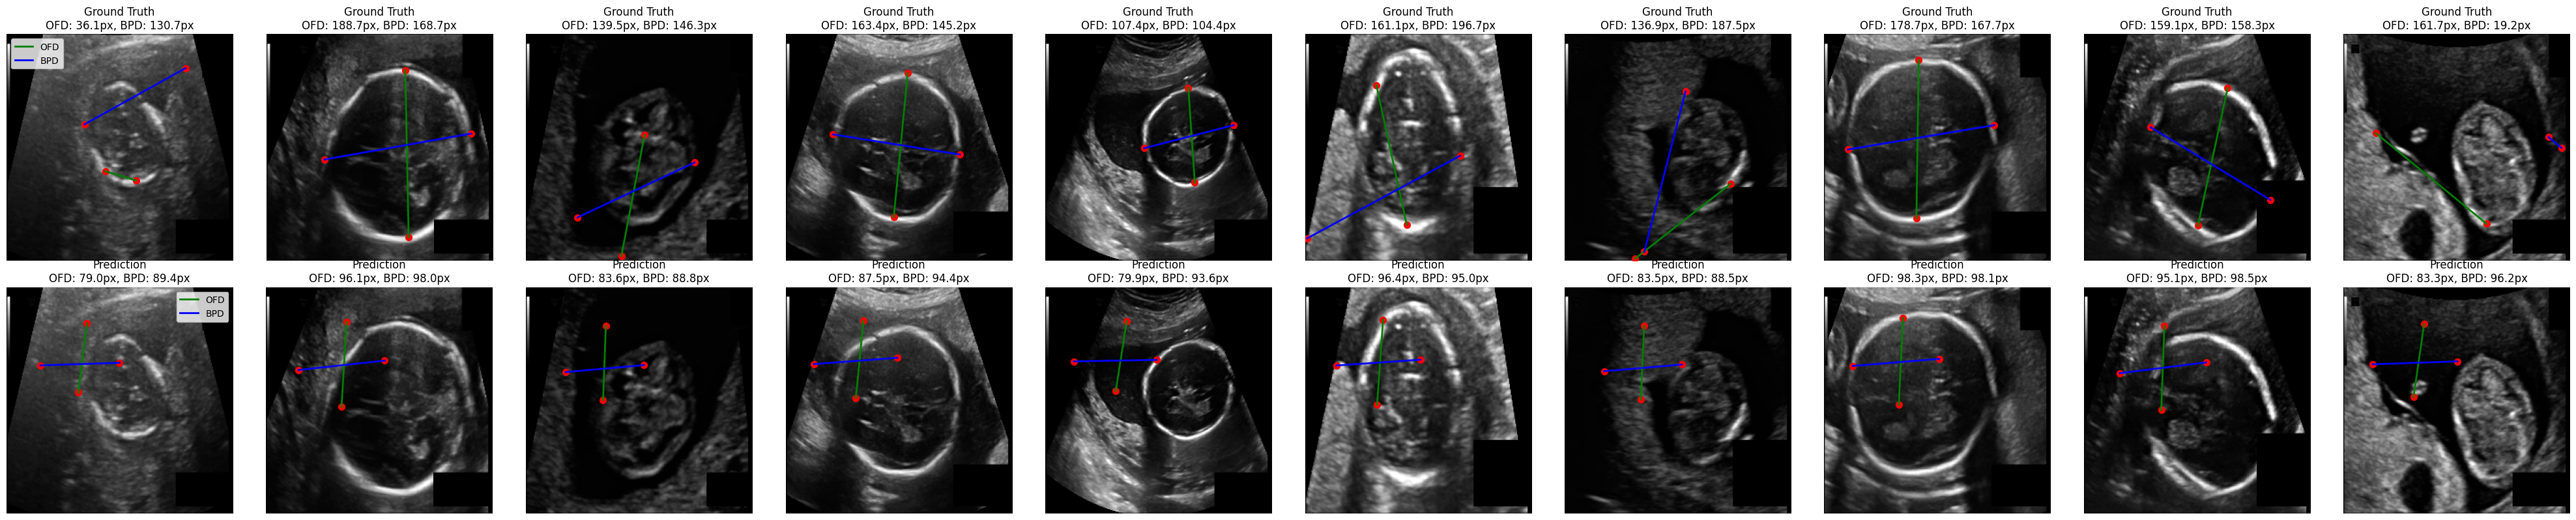

✓ Predictions saved to: experiments/exp_20251227_121436/predictions_visual_10samples.png

✅ Visualization complete!


In [28]:
import os
import torch
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import Dataset
import cv2
import pandas as pd


class FetalLandmarkDataset(Dataset):
    """Dataset for fetal ultrasound landmark detection"""

    def __init__(self, csv_path, image_dir, img_size=256):
        self.df = pd.read_csv(csv_path)
        self.image_dir = image_dir
        self.img_size = img_size
        self.original_sizes = {}

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]

        # Load image
        img_name = row['image_name']
        img_path = os.path.join(self.image_dir, img_name)
        image = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)

        if image is None:
            raise FileNotFoundError(f"Image not found: {img_path}")

        # Store original size
        orig_h, orig_w = image.shape
        self.original_sizes[img_name] = (orig_w, orig_h)

        # Resize image
        image = cv2.resize(image, (self.img_size, self.img_size))

        # Normalize image to [0, 1]
        image = image.astype(np.float32) / 255.0

        # Convert to tensor (1, H, W)
        image = torch.tensor(image, dtype=torch.float32).unsqueeze(0)

        # Extract landmarks (8 values)
        landmarks = row[1:9].values.astype(np.float32)

        # Normalize coordinates to [0, 1]
        landmarks[0::2] = landmarks[0::2] / orig_w  # x coordinates
        landmarks[1::2] = landmarks[1::2] / orig_h  # y coordinates

        landmarks = torch.tensor(landmarks, dtype=torch.float32)

        return image, landmarks, img_name


import torch.nn as nn

class LandmarkCNN(nn.Module):
    """CNN for landmark regression"""

    def __init__(self, num_landmarks=8):
        super(LandmarkCNN, self).__init__()

        # Feature extraction layers
        self.features = nn.Sequential(
            # Block 1
            nn.Conv2d(1, 32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(inplace=True),
            nn.Conv2d(32, 32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2, 2),

            # Block 2
            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.Conv2d(64, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2, 2),

            # Block 3
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.Conv2d(128, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2, 2),

            # Block 4
            nn.Conv2d(128, 256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2, 2),
        )

        # Regression head
        self.regressor = nn.Sequential(
            nn.Flatten(),
            nn.Linear(256 * 16 * 16, 512),
            nn.ReLU(inplace=True),
            nn.Dropout(0.5),
            nn.Linear(512, 256),
            nn.ReLU(inplace=True),
            nn.Dropout(0.3),
            nn.Linear(256, num_landmarks)
        )

    def forward(self, x):
        x = self.features(x)
        x = self.regressor(x)
        return x



def calculate_measurements(landmarks, img_size=256):
    """Calculate BPD and OFD from predicted landmarks"""
    landmarks_pixels = landmarks * img_size

    ofd_1 = landmarks_pixels[0:2]
    ofd_2 = landmarks_pixels[2:4]
    bpd_1 = landmarks_pixels[4:6]
    bpd_2 = landmarks_pixels[6:8]

    OFD = np.linalg.norm(ofd_1 - ofd_2)
    BPD = np.linalg.norm(bpd_1 - bpd_2)

    return OFD, BPD


def visualize_predictions(model, dataset, device, num_samples=4, save_path='predictions_only.png'):
    """Visualize model predictions"""
    model.eval()

    fig, axes = plt.subplots(2, num_samples, figsize=(4*num_samples, 8))
    if num_samples == 1:
        axes = axes.reshape(-1, 1)

    indices = np.random.choice(len(dataset), num_samples, replace=False)

    with torch.no_grad():
        for i, idx in enumerate(indices):
            image, gt_landmarks, img_name = dataset[idx]
            image_input = image.unsqueeze(0).to(device)

            # Predict
            pred_landmarks = model(image_input).cpu().numpy()[0]
            gt_landmarks_np = gt_landmarks.numpy()

            # Denormalize
            pred_pixels = pred_landmarks * 256
            gt_pixels = gt_landmarks_np * 256

            # Calculate measurements
            pred_ofd, pred_bpd = calculate_measurements(pred_landmarks)
            gt_ofd, gt_bpd = calculate_measurements(gt_landmarks_np)

            # Plot
            img_display = image.squeeze().numpy()

            # Ground truth
            axes[0, i].imshow(img_display, cmap='gray')
            axes[0, i].plot([gt_pixels[0], gt_pixels[2]], [gt_pixels[1], gt_pixels[3]],
                           'g-', linewidth=2, label='OFD')
            axes[0, i].plot([gt_pixels[4], gt_pixels[6]], [gt_pixels[5], gt_pixels[7]],
                           'b-', linewidth=2, label='BPD')
            axes[0, i].scatter(gt_pixels[0::2], gt_pixels[1::2], c='red', s=50)
            axes[0, i].set_title(f'Ground Truth\nOFD: {gt_ofd:.1f}px, BPD: {gt_bpd:.1f}px')
            axes[0, i].axis('off')
            if i == 0:
                axes[0, i].legend()

            # Prediction
            axes[1, i].imshow(img_display, cmap='gray')
            axes[1, i].plot([pred_pixels[0], pred_pixels[2]], [pred_pixels[1], pred_pixels[3]],
                           'g-', linewidth=2, label='OFD')
            axes[1, i].plot([pred_pixels[4], pred_pixels[6]], [pred_pixels[5], pred_pixels[7]],
                           'b-', linewidth=2, label='BPD')
            axes[1, i].scatter(pred_pixels[0::2], pred_pixels[1::2], c='red', s=50)
            axes[1, i].set_title(f'Prediction\nOFD: {pred_ofd:.1f}px, BPD: {pred_bpd:.1f}px')
            axes[1, i].axis('off')
            if i == 0:
                axes[1, i].legend()

    plt.tight_layout()
    plt.savefig(save_path, dpi=150, bbox_inches='tight')
    plt.show()
    print(f"✓ Predictions saved to: {save_path}")


def run_visualization_only():
    """Run only the visualization without training"""


    CSV_PATH = "role_challenge_dataset_ground_truth.csv"
    IMAGE_DIR = "images"
    EXPERIMENT_DIR = "experiments/exp_20251227_121436"
    MODEL_CHECKPOINT = "checkpoint_best.pth"
    NUM_SAMPLES = 10


    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    print(f"Using device: {device}\n")

    # Load dataset
    print("Loading dataset...")
    dataset = FetalLandmarkDataset(CSV_PATH, IMAGE_DIR, img_size=256)
    print(f"Dataset size: {len(dataset)} images\n")

    # Load model
    print("Loading model...")
    model = LandmarkCNN(num_landmarks=8).to(device)

    # Load trained weights
    checkpoint_path = os.path.join(EXPERIMENT_DIR, MODEL_CHECKPOINT)

    if not os.path.exists(checkpoint_path):
        print(f"❌ Error: Checkpoint not found at {checkpoint_path}")
        print("\nAvailable experiments:")
        if os.path.exists("experiments"):
            for exp_dir in os.listdir("experiments"):
                exp_path = os.path.join("experiments", exp_dir)
                if os.path.isdir(exp_path):
                    print(f"  - {exp_dir}")
        return

    checkpoint = torch.load(checkpoint_path, map_location=device, weights_only=False)
    model.load_state_dict(checkpoint['model_state_dict'])
    model.eval()

    print(f"✓ Loaded model from: {checkpoint_path}")
    print(f"  Epoch: {checkpoint['epoch']}")
    print(f"  Validation Error: {checkpoint['val_error']:.2f}px\n")


    print(f"Generating predictions for {NUM_SAMPLES} random images...\n")

    save_path = os.path.join(EXPERIMENT_DIR, f"predictions_visual_{NUM_SAMPLES}samples.png")
    visualize_predictions(model, dataset, device, num_samples=NUM_SAMPLES, save_path=save_path)

    print(f"\n{'='*60}")
    print("✅ Visualization complete!")
    print(f"{'='*60}")

if __name__ == '__main__':
    run_visualization_only()